# ArcFace and CosFace Models for ASD Detection on AutismDataset
Optimized training of ArcFace and CosFace models with proper loss functions and stable training procedures, adapted for the AutismDataset structure

This notebook implements ArcFace and CosFace models with careful attention to numerical stability and proper loss implementation to ensure successful training convergence on the AutismDataset.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## Dataset Structure Analysis and Loading

In [2]:
def create_dataset_from_folders(base_path):
    """
    Create a DataFrame from the AutismDataset folder structure
    Handles mixed structure: train/test (mixed files), valid (subdirectories)
    """
    dataset_list = []
    
    # Process train and test folders (mixed structure)
    for split in ['train', 'test']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            for filename in os.listdir(split_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    # Extract label from filename
                    if filename.startswith('Autistic'):
                        label = 'Autistic'
                    elif filename.startswith('Non_Autistic'):
                        label = 'Non_Autistic'
                    else:
                        continue  # Skip files that don't match expected pattern
                    
                    dataset_list.append({
                        'image_path': os.path.join(split_path, filename),
                        'labels': label,
                        'split': split
                    })
    
    # Process valid folder (subdirectory structure)
    valid_path = os.path.join(base_path, 'valid')
    if os.path.exists(valid_path):
        for label_folder in os.listdir(valid_path):
            label_folder_path = os.path.join(valid_path, label_folder)
            if os.path.isdir(label_folder_path):
                # Map folder names to consistent labels
                if label_folder.lower() in ['autistic', 'autism']:
                    label = 'Autistic'
                elif label_folder.lower() in ['non_autistic', 'typical']:
                    label = 'Non_Autistic'
                else:
                    continue
                
                for filename in os.listdir(label_folder_path):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        dataset_list.append({
                            'image_path': os.path.join(label_folder_path, filename),
                            'labels': label,
                            'split': 'valid'
                        })
    
    return pd.DataFrame(dataset_list)

# Load the dataset
dataset_path = '/kaggle/input/autism-image-data/AutismDataset'
print("Loading AutismDataset...")
full_dataset = create_dataset_from_folders(dataset_path)

print(f"Total samples loaded: {len(full_dataset)}")
print(f"Label distribution:\n{full_dataset['labels'].value_counts()}")
print(f"Split distribution:\n{full_dataset['split'].value_counts()}")

# Separate into train, validation, and test sets
train_data = full_dataset[full_dataset['split'] == 'train'].copy()
valid_data = full_dataset[full_dataset['split'] == 'valid'].copy()
test_data = full_dataset[full_dataset['split'] == 'test'].copy()

print(f"\nTrain samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

Loading AutismDataset...
Total samples loaded: 2940
Label distribution:
labels
Non_Autistic    1470
Autistic        1470
Name: count, dtype: int64
Split distribution:
split
train    2540
test      300
valid     100
Name: count, dtype: int64

Train samples: 2540
Validation samples: 100
Test samples: 300


## Training Configuration

In [3]:
# Training configuration
BATCH_SIZE = 32
NUM_WORKERS = 2  # Adjusted for local training
IMAGE_SIZE = 224
EMBEDDING_SIZE = 512
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

## Optimized Data Preprocessing
Carefully designed transforms to maintain facial features while providing effective augmentation

In [4]:
# Minimal preprocessing for face recognition models without augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Custom Dataset Class for AutismDataset

In [5]:
class AutismDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        self.data = dataframe.copy()
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['labels'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['labels'])
        
        self.image_paths = self.data['image_path'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        return self.label_encoder
    
    def get_class_names(self):
        return self.label_encoder.classes_

## Create Datasets and Data Loaders

In [6]:
# Create datasets
train_dataset = AutismDataset(
    dataframe=train_data, 
    transform=train_transform,
    fit_label_encoder=True  
)

le = train_dataset.get_label_encoder()

val_dataset = AutismDataset(
    dataframe=valid_data,
    transform=val_test_transform,
    label_encoder=le
)

test_dataset = AutismDataset(
    dataframe=test_data,
    transform=val_test_transform,
    label_encoder=le
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {le.classes_}")
print(f"Number of classes: {len(le.classes_)}")

# Verify data loading
print("\nTesting data loading...")
sample_batch = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=False)))
print(f"Sample batch shape: {sample_batch[0].shape}")
print(f"Sample labels: {sample_batch[1]}")

Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']
Number of classes: 2

Testing data loading...
Sample batch shape: torch.Size([4, 3, 224, 224])
Sample labels: tensor([1, 0, 1, 0])


In [7]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 79
Validation batches: 4
Test batches: 10


## Improved ArcFace Implementation
Numerically stable implementation with proper initialization and gradient clipping

In [8]:
class ArcMarginProduct(nn.Module):
    """Improved ArcFace implementation with numerical stability"""
    def __init__(self, in_features, out_features, s=30.0, m=0.30, easy_margin=True, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # Normalize features and weights
        x = F.normalize(input, p=2, dim=1)
        W = F.normalize(self.weight, p=2, dim=1)
        
        # Compute cosine similarity
        cosine = F.linear(x, W)
        cosine = torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7)  # Numerical stability
        
        # Compute sine
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        
        # Compute phi (cosine with margin)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        # Convert label to one-hot
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # Apply label smoothing if specified
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        
        # Final output
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

## Improved CosFace Implementation
Stable implementation with proper margin handling

In [9]:
class AddMarginProduct(nn.Module):
    """Improved CosFace implementation with numerical stability"""
    def __init__(self, in_features, out_features, s=30.0, m=0.25):
        super(AddMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # Normalize features and weights
        x = F.normalize(input, p=2, dim=1)
        W = F.normalize(self.weight, p=2, dim=1)
        
        # Compute cosine similarity
        cosine = F.linear(x, W)
        cosine = torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7)  # Numerical stability
        
        # Add margin
        phi = cosine - self.m
        
        # Convert label to one-hot
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # Final output
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

## Model Architecture Definitions

In [10]:
class ArcFaceModel(nn.Module):
    def __init__(self, backbone='resnet50', num_classes=2, embedding_size=512, pretrained=True):
        super(ArcFaceModel, self).__init__()
        
        # Load backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            backbone_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
            backbone_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError("Backbone must be 'resnet50' or 'resnet18'")
        
        # Embedding layer
        self.embedding = nn.Sequential(
            nn.Linear(backbone_features, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        
        # ArcFace margin product
        self.arc_margin = ArcMarginProduct(embedding_size, num_classes, s=30.0, m=0.30, easy_margin=True)
        
        # For inference (when labels are not provided)
        self.classifier = nn.Linear(embedding_size, num_classes)
        
    def forward(self, x, labels=None):
        # Extract features
        features = self.backbone(x)
        embeddings = self.embedding(features)
        
        if labels is not None and self.training:
            # Use ArcFace loss during training
            return self.arc_margin(embeddings, labels)
        else:
            # Use regular classifier for inference
            return self.classifier(embeddings)

In [11]:
class CosFaceModel(nn.Module):
    def __init__(self, backbone='resnet50', num_classes=2, embedding_size=512, pretrained=True):
        super(CosFaceModel, self).__init__()
        
        # Load backbone
        if backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            backbone_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
            backbone_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError("Backbone must be 'resnet50' or 'resnet18'")
        
        # Embedding layer
        self.embedding = nn.Sequential(
            nn.Linear(backbone_features, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        
        # CosFace margin product
        self.cos_margin = AddMarginProduct(embedding_size, num_classes, s=30.0, m=0.25)
        
        # For inference (when labels are not provided)
        self.classifier = nn.Linear(embedding_size, num_classes)
        
    def forward(self, x, labels=None):
        # Extract features
        features = self.backbone(x)
        embeddings = self.embedding(features)
        
        if labels is not None and self.training:
            # Use CosFace loss during training
            return self.cos_margin(embeddings, labels)
        else:
            # Use regular classifier for inference
            return self.classifier(embeddings)

## Enhanced Training Framework
Improved trainer with better stability, learning rate scheduling, and gradient monitoring

In [12]:
class MarginLossTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Store label encoder
        try:
            self.label_encoder = train_loader.dataset.get_label_encoder()
        except:
            self.label_encoder = None
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []
        
    def train_model(self, num_epochs=30, lr=0.001, weight_decay=1e-4, save_best=True, model_name="margin_model"):
        """Enhanced training with better stability"""
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing
        
        # Separate learning rates for backbone and margin layers
        backbone_params = []
        margin_params = []
        
        for name, param in self.model.named_parameters():
            if 'arc_margin' in name or 'cos_margin' in name or 'classifier' in name:
                margin_params.append(param)
            else:
                backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': lr * 0.1},  # Lower LR for backbone
            {'params': margin_params, 'lr': lr}  # Higher LR for margin layers
        ], weight_decay=weight_decay)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )
        
        # Best model tracking
        best_val_acc = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 10
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Training phase
            self.model.train()
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            train_pbar = tqdm(self.train_loader, desc='Training')
            
            for inputs, labels in train_pbar:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                optimizer.zero_grad()
                
                # Forward pass with labels for margin loss
                outputs = self.model(inputs, labels)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
                
                # Update progress bar
                current_acc = running_corrects.double() / total_samples
                train_pbar.set_postfix({
                    'Loss': f'{running_loss/total_samples:.4f}',
                    'Acc': f'{current_acc:.4f}',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
                })
            
            # Calculate training metrics
            train_loss = running_loss / total_samples
            train_acc = running_corrects.double() / total_samples
            
            # Validation phase
            self.model.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            val_total_samples = 0
            
            val_pbar = tqdm(self.val_loader, desc='Validation')
            
            with torch.no_grad():
                for inputs, labels in val_pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Forward pass without labels for regular inference
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Statistics
                    val_running_loss += loss.item() * inputs.size(0)
                    val_running_corrects += torch.sum(preds == labels.data)
                    val_total_samples += inputs.size(0)
                    
                    # Update progress bar
                    current_val_acc = val_running_corrects.double() / val_total_samples
                    val_pbar.set_postfix({
                        'Loss': f'{val_running_loss/val_total_samples:.4f}',
                        'Acc': f'{current_val_acc:.4f}'
                    })
            
            # Calculate validation metrics
            val_loss = val_running_loss / val_total_samples
            val_acc = val_running_corrects.double() / val_total_samples
            
            # Learning rate step
            scheduler.step()
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc.cpu())
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc.cpu())
            self.learning_rates.append(optimizer.param_groups[0]['lr'])
            
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = copy.deepcopy(self.model.state_dict())
                patience_counter = 0
                if save_best:
                    torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                    print(f'✓ New best model saved with validation accuracy: {best_val_acc:.4f}')
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_val_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)  # No labels for inference
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Get class names
        unique_labels = np.unique(all_labels)
        unique_preds = np.unique(all_preds)
        
        try:
            class_names = self.label_encoder.classes_ if self.label_encoder else [f'Class_{i}' for i in range(len(unique_labels))]
        except:
            class_names = [f'Class_{i}' for i in range(len(unique_labels))]
        
        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                  target_names=class_names,
                                  zero_division=0))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return test_acc, all_preds, all_labels
    
    def plot_training_history(self, save_path=None):
        """Plot comprehensive training history"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        # Plot learning rate
        ax3.plot(self.learning_rates, label='Learning Rate', color='red')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.legend()
        ax3.grid(True)
        ax3.set_yscale('log')
        
        # Plot validation accuracy zoomed
        ax4.plot(self.val_accuracies, label='Validation Accuracy', marker='s', color='orange')
        ax4.set_title('Validation Accuracy (Detailed)')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

## GPU Configuration

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon) acceleration")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA version: 12.4


## 1. ArcFace Model Training

In [14]:
print("Creating ArcFace model...")
arcface_model = ArcFaceModel(
    backbone='resnet50', 
    num_classes=len(le.classes_), 
    embedding_size=EMBEDDING_SIZE, 
    pretrained=True
)

print(f"Model created with {sum(p.numel() for p in arcface_model.parameters())} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in arcface_model.parameters() if p.requires_grad)}")

Creating ArcFace model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Model created with 24560194 parameters
Trainable parameters: 24560194


In [15]:
print("Initializing ArcFace trainer...")
arcface_trainer = MarginLossTrainer(
    arcface_model, 
    train_loader, 
    val_loader, 
    test_loader, 
    device
)

Initializing ArcFace trainer...


In [16]:
print("Starting ArcFace training...")
trained_arcface = arcface_trainer.train_model(
    num_epochs=NUM_EPOCHS, 
    lr=LEARNING_RATE, 
    weight_decay=1e-4,
    model_name="arcface_autism_dataset"
)

Starting ArcFace training...
Starting training for 30 epochs...
------------------------------------------------------------
Epoch 1/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s, Loss=0.6701, Acc=0.5700]


Train Loss: 2.5741 Acc: 0.5811
Val Loss: 0.6701 Acc: 0.5700
Learning Rate: 0.000098
✓ New best model saved with validation accuracy: 0.5700

Epoch 2/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.00it/s, Loss=0.6596, Acc=0.6100]


Train Loss: 1.0875 Acc: 0.8153
Val Loss: 0.6596 Acc: 0.6100
Learning Rate: 0.000091
✓ New best model saved with validation accuracy: 0.6100

Epoch 3/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.43it/s, Loss=0.7469, Acc=0.4900]


Train Loss: 0.6036 Acc: 0.9169
Val Loss: 0.7469 Acc: 0.4900
Learning Rate: 0.000080

Epoch 4/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.75it/s, Loss=0.8748, Acc=0.4400]


Train Loss: 0.5763 Acc: 0.9233
Val Loss: 0.8748 Acc: 0.4400
Learning Rate: 0.000066

Epoch 5/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.18it/s, Loss=0.7931, Acc=0.5300]


Train Loss: 0.4022 Acc: 0.9470
Val Loss: 0.7931 Acc: 0.5300
Learning Rate: 0.000051

Epoch 6/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.16it/s, Loss=0.7603, Acc=0.4900]


Train Loss: 0.3343 Acc: 0.9597
Val Loss: 0.7603 Acc: 0.4900
Learning Rate: 0.000035

Epoch 7/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.23it/s, Loss=0.7367, Acc=0.5000]


Train Loss: 0.2812 Acc: 0.9763
Val Loss: 0.7367 Acc: 0.5000
Learning Rate: 0.000021

Epoch 8/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.39it/s, Loss=0.8073, Acc=0.4400]


Train Loss: 0.2653 Acc: 0.9830
Val Loss: 0.8073 Acc: 0.4400
Learning Rate: 0.000010

Epoch 9/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.57it/s, Loss=0.7686, Acc=0.4700]


Train Loss: 0.2469 Acc: 0.9929
Val Loss: 0.7686 Acc: 0.4700
Learning Rate: 0.000003

Epoch 10/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.04it/s, Loss=0.7481, Acc=0.4700]


Train Loss: 0.2331 Acc: 0.9945
Val Loss: 0.7481 Acc: 0.4700
Learning Rate: 0.000100

Epoch 11/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s, Loss=0.6637, Acc=0.5700]


Train Loss: 0.3067 Acc: 0.9648
Val Loss: 0.6637 Acc: 0.5700
Learning Rate: 0.000099

Epoch 12/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.60it/s, Loss=0.8786, Acc=0.5800]

Train Loss: 0.3637 Acc: 0.9529
Val Loss: 0.8786 Acc: 0.5800
Learning Rate: 0.000098
Early stopping triggered after 12 epochs
Training complete in 2m 54s
Best validation accuracy: 0.6100


In [17]:
print("Evaluating ArcFace model...")
arcface_test_acc, arcface_preds, arcface_labels = arcface_trainer.evaluate_model()

Evaluating ArcFace model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]

Test Accuracy: 58.00%
Test Loss: 0.6564

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.58      0.59      0.58       150
Non_Autistic       0.58      0.57      0.58       150

    accuracy                           0.58       300
   macro avg       0.58      0.58      0.58       300
weighted avg       0.58      0.58      0.58       300


Confusion Matrix:
[[88 62]
 [64 86]]


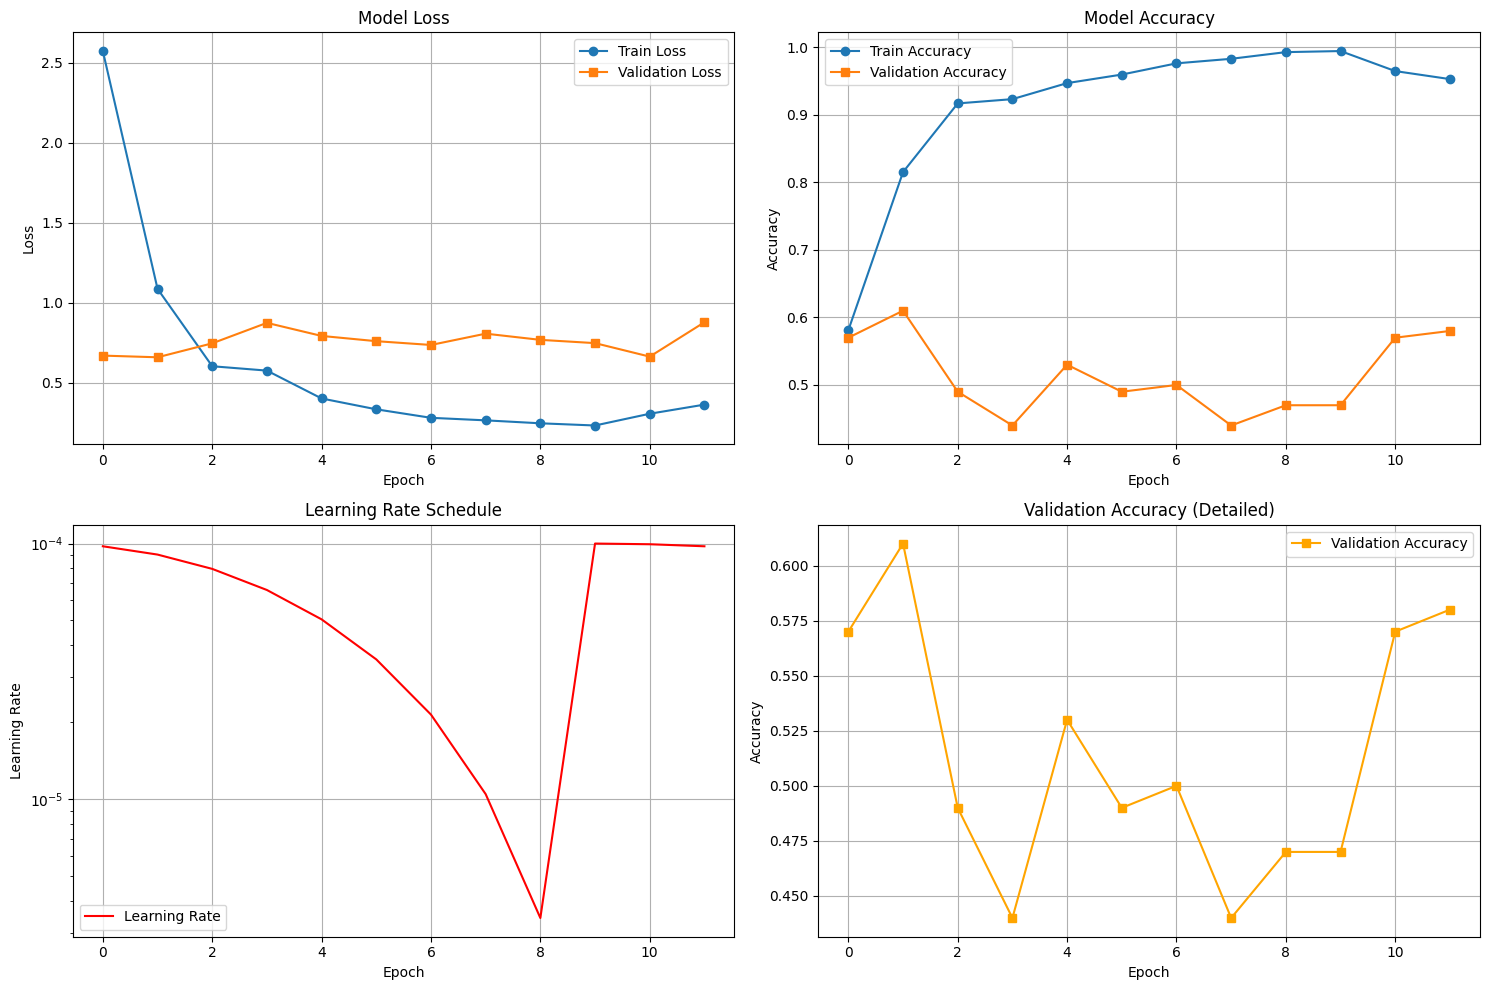

In [18]:
arcface_trainer.plot_training_history(save_path='arcface_autism_dataset_training_history.png')

## 2. CosFace Model Training

In [19]:
print("Creating CosFace model...")
cosface_model = CosFaceModel(
    backbone='resnet50', 
    num_classes=len(le.classes_), 
    embedding_size=EMBEDDING_SIZE, 
    pretrained=True
)

print(f"Model created with {sum(p.numel() for p in cosface_model.parameters())} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in cosface_model.parameters() if p.requires_grad)}")

Creating CosFace model...
Model created with 24560194 parameters
Trainable parameters: 24560194


In [20]:
print("Initializing CosFace trainer...")
cosface_trainer = MarginLossTrainer(
    cosface_model, 
    train_loader, 
    val_loader, 
    test_loader, 
    device
)

Initializing CosFace trainer...


In [21]:
print("Starting CosFace training...")
trained_cosface = cosface_trainer.train_model(
    num_epochs=NUM_EPOCHS, 
    lr=LEARNING_RATE, 
    weight_decay=1e-4,
    model_name="cosface_autism_dataset"
)

Starting CosFace training...
Starting training for 30 epochs...
------------------------------------------------------------
Epoch 1/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.26it/s, Loss=0.7251, Acc=0.5400]


Train Loss: 3.9455 Acc: 0.5510
Val Loss: 0.7251 Acc: 0.5400
Learning Rate: 0.000098
✓ New best model saved with validation accuracy: 0.5400

Epoch 2/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.80it/s, Loss=0.7726, Acc=0.3600]


Train Loss: 1.6583 Acc: 0.7935
Val Loss: 0.7726 Acc: 0.3600
Learning Rate: 0.000091

Epoch 3/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.93it/s, Loss=0.7407, Acc=0.3600]


Train Loss: 1.0330 Acc: 0.8774
Val Loss: 0.7407 Acc: 0.3600
Learning Rate: 0.000080

Epoch 4/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.07it/s, Loss=0.7371, Acc=0.3300]


Train Loss: 0.8731 Acc: 0.9193
Val Loss: 0.7371 Acc: 0.3300
Learning Rate: 0.000066

Epoch 5/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.19it/s, Loss=0.7403, Acc=0.3000]


Train Loss: 0.6067 Acc: 0.9466
Val Loss: 0.7403 Acc: 0.3000
Learning Rate: 0.000051

Epoch 6/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.87it/s, Loss=0.7404, Acc=0.3200]


Train Loss: 0.4584 Acc: 0.9672
Val Loss: 0.7404 Acc: 0.3200
Learning Rate: 0.000035

Epoch 7/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.23it/s, Loss=0.7398, Acc=0.3000]


Train Loss: 0.3450 Acc: 0.9842
Val Loss: 0.7398 Acc: 0.3000
Learning Rate: 0.000021

Epoch 8/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.76it/s, Loss=0.7351, Acc=0.3200]


Train Loss: 0.2852 Acc: 0.9877
Val Loss: 0.7351 Acc: 0.3200
Learning Rate: 0.000010

Epoch 9/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.87it/s, Loss=0.7364, Acc=0.2400]


Train Loss: 0.2285 Acc: 0.9960
Val Loss: 0.7364 Acc: 0.2400
Learning Rate: 0.000003

Epoch 10/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.82it/s, Loss=0.7373, Acc=0.2600]


Train Loss: 0.2091 Acc: 0.9980
Val Loss: 0.7373 Acc: 0.2600
Learning Rate: 0.000100

Epoch 11/30
----------


Validation: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s, Loss=0.7491, Acc=0.3000]


Train Loss: 0.4705 Acc: 0.9723
Val Loss: 0.7491 Acc: 0.3000
Learning Rate: 0.000099
Early stopping triggered after 11 epochs
Training complete in 2m 38s
Best validation accuracy: 0.5400


In [22]:
print("Evaluating CosFace model...")
cosface_test_acc, cosface_preds, cosface_labels = cosface_trainer.evaluate_model()

Evaluating CosFace model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  8.07it/s]

Test Accuracy: 50.33%
Test Loss: 0.7226

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.50      0.50      0.50       150
Non_Autistic       0.50      0.51      0.50       150

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.50      0.50      0.50       300


Confusion Matrix:
[[75 75]
 [74 76]]


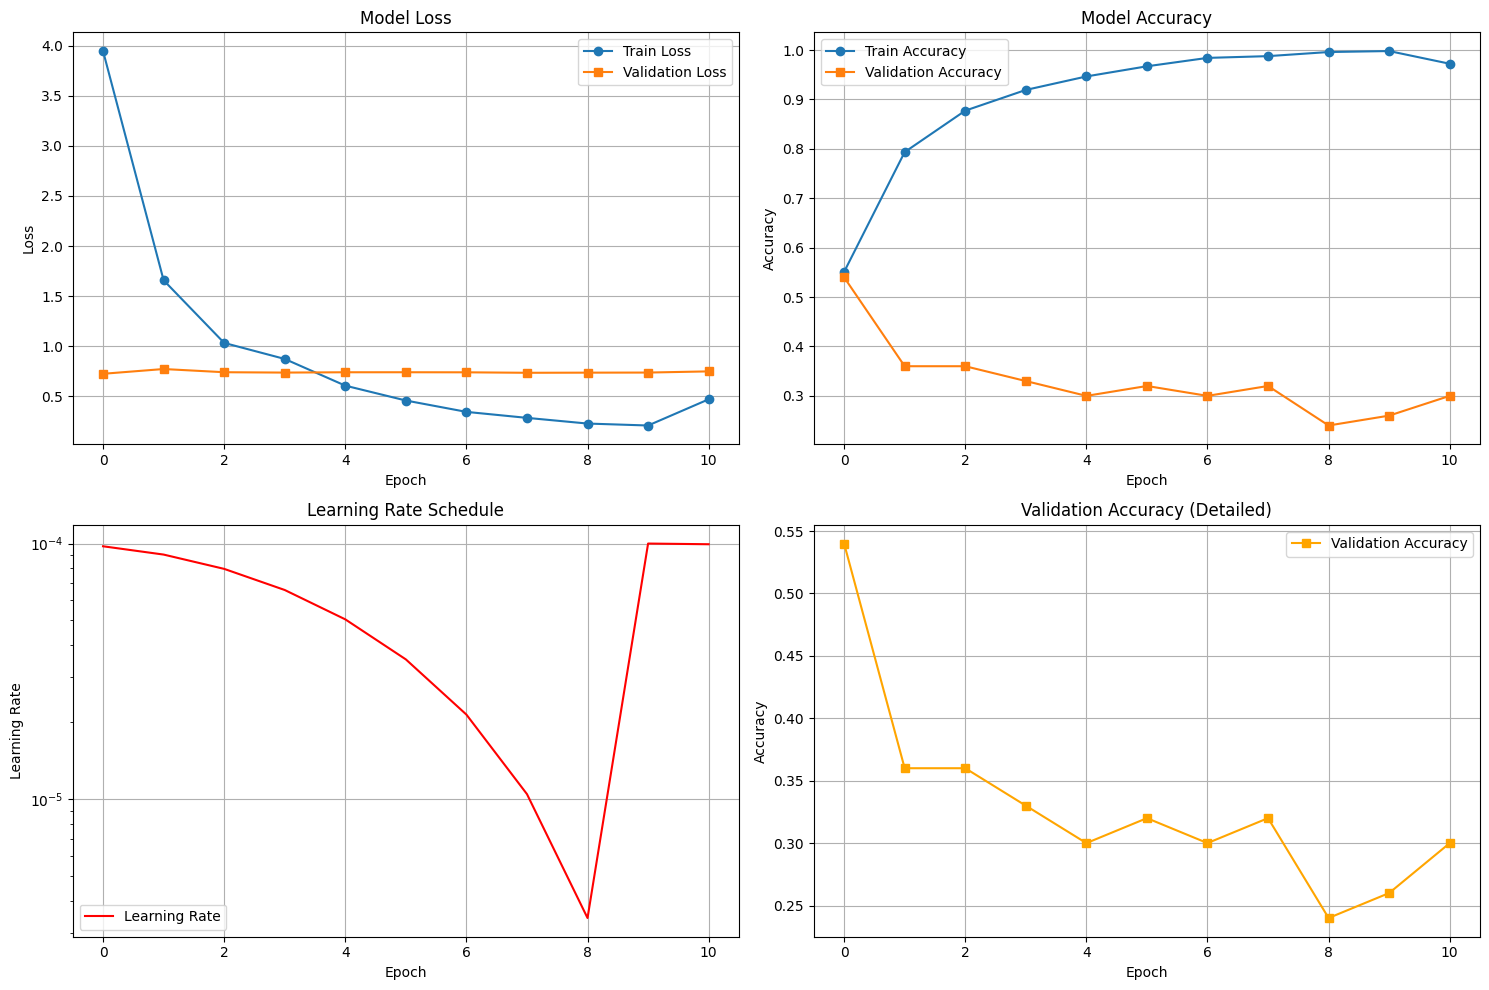

In [23]:
cosface_trainer.plot_training_history(save_path='cosface_autism_dataset_training_history.png')

## Model Comparison and Results Summary

ArcFace vs CosFace Results Summary:
  Model  Test Accuracy (%)                Final Train Accuracy                  Final Val Accuracy                   Best Val Accuracy
ArcFace              58.00 tensor(0.9529, dtype=torch.float64) tensor(0.5800, dtype=torch.float64) tensor(0.6100, dtype=torch.float64)
CosFace              50.33 tensor(0.9723, dtype=torch.float64) tensor(0.3000, dtype=torch.float64) tensor(0.5400, dtype=torch.float64)


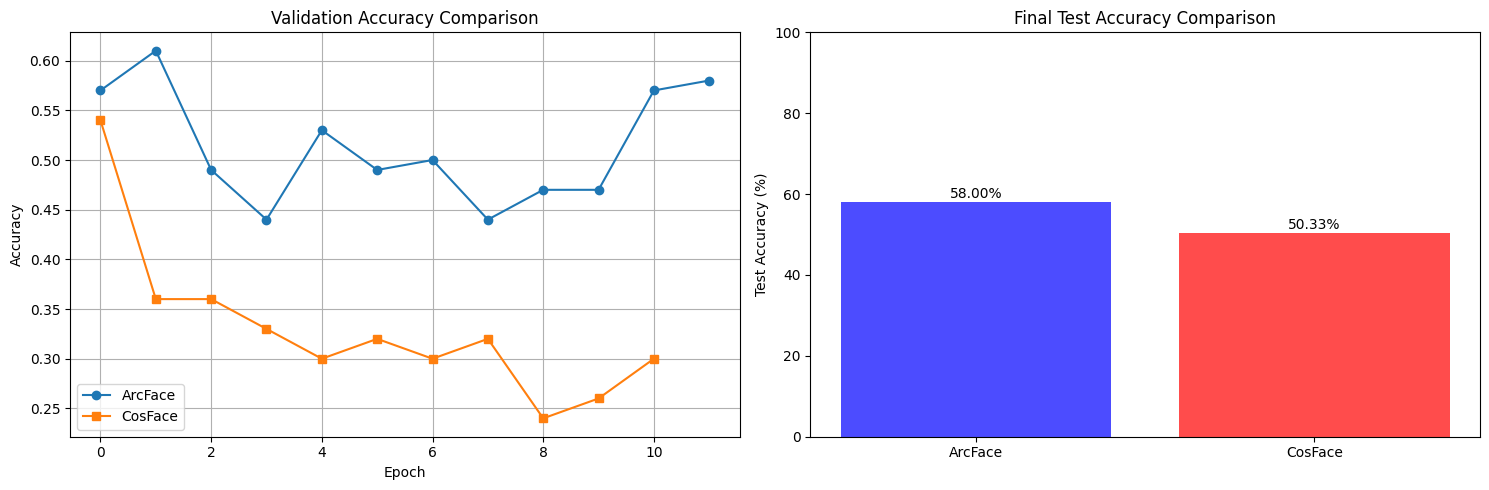

In [24]:
# Create a comparison summary
results_summary = {
    'Model': ['ArcFace', 'CosFace'],
    'Test Accuracy (%)': [arcface_test_acc, cosface_test_acc],
    'Final Train Accuracy': [arcface_trainer.train_accuracies[-1], cosface_trainer.train_accuracies[-1]],
    'Final Val Accuracy': [arcface_trainer.val_accuracies[-1], cosface_trainer.val_accuracies[-1]],
    'Best Val Accuracy': [max(arcface_trainer.val_accuracies), max(cosface_trainer.val_accuracies)]
}

results_df = pd.DataFrame(results_summary)
print("ArcFace vs CosFace Results Summary:")
print("=" * 50)
print(results_df.to_string(index=False, float_format='%.2f'))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Validation accuracy comparison
ax1.plot(arcface_trainer.val_accuracies, label='ArcFace', marker='o')
ax1.plot(cosface_trainer.val_accuracies, label='CosFace', marker='s')
ax1.set_title('Validation Accuracy Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Test accuracy bar plot
models = ['ArcFace', 'CosFace']
test_accs = [arcface_test_acc, cosface_test_acc]
ax2.bar(models, test_accs, color=['blue', 'red'], alpha=0.7)
ax2.set_title('Final Test Accuracy Comparison')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_ylim(0, 100)
for i, acc in enumerate(test_accs):
    ax2.text(i, acc + 1, f'{acc:.2f}%', ha='center')

plt.tight_layout()
plt.savefig('arcface_cosface_comparison.png')
plt.show()

## Save Model Weights

In [25]:
# Save final trained models
torch.save(trained_arcface.state_dict(), 'final_arcface_autism_dataset.pth')
torch.save(trained_cosface.state_dict(), 'final_cosface_autism_dataset.pth')

# Save label encoder for future use
import pickle
with open('label_encoder_autism_dataset.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model weights and label encoder saved successfully!")
print("Files saved:")
print("- final_arcface_autism_dataset.pth")
print("- final_cosface_autism_dataset.pth") 
print("- label_encoder_autism_dataset.pkl")
print("- best_arcface_autism_dataset.pth")
print("- best_cosface_autism_dataset.pth")

Model weights and label encoder saved successfully!
Files saved:
- final_arcface_autism_dataset.pth
- final_cosface_autism_dataset.pth
- label_encoder_autism_dataset.pkl
- best_arcface_autism_dataset.pth
- best_cosface_autism_dataset.pth
